Import Data

In [1]:
# Importing os for getting path names for data
import os
# Importing pandas 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = os.path.join('data','zippedData')
files = os.listdir(data_path)

In [3]:
import_paths = [os.path.join(data_path,file) for file in files]

In [4]:
import_paths

['data/zippedData/imdb.title.crew.csv.gz',
 'data/zippedData/tmdb.movies.csv.gz',
 'data/zippedData/imdb.title.akas.csv.gz',
 'data/zippedData/imdb.title.ratings.csv.gz',
 'data/zippedData/imdb.name.basics.csv.gz',
 'data/zippedData/rt.reviews.tsv.gz',
 'data/zippedData/imdb.title.basics.csv.gz',
 'data/zippedData/rt.movie_info.tsv.gz',
 'data/zippedData/tn.movie_budgets.csv.gz',
 'data/zippedData/bom.movie_gross.csv.gz',
 'data/zippedData/imdb.title.principals.csv.gz']

In [5]:
data = {}
for path in import_paths:
    try:
        df = pd.read_csv(path) #this will fail on the .tsv
    except:
        df = pd.read_csv(path,delimiter='\t', encoding='unicode_escape')
    data[path.split('/')[-1]] = df

In [6]:
genre_id_to_string = {28:'action',
                      16:'animated',
                      99:'documentary',
                      18:'drama',
                      10751:'family',
                      14:'fantasy',
                      36:'history',
                      35:'comedy',
                      10752:'war',
                      80:'crime',
                      10402:'music',
                      9648:'mystery',
                      10749:'romance',
                      878:'sci-fi',
                      27:'horror',
                      10770:'TV-movie',
                      53:'thriller',
                      37:'western',
                      12:'adventure'}

In [7]:
def convert_id_to_name(id_list):
    id_list = id_list[1:-1].replace(',','').split()
    for id in enumerate(id_list):
        id_list[id[0]] = genre_id_to_string[int(id[1])]
    return(id_list)


# Data Preparation

In [8]:
# Performing an outer merge of IMDB title basic and title ratings datasets on 
# movie id column, 'tconst'. 
# This is to gather movie information from the IMDb datatsets.
imdb_movie = data['imdb.title.basics.csv.gz'].merge(data['imdb.title.ratings.csv.gz'], how = 'outer', on = 'tconst')

# Performing an outer merge on the IMDB movie dataframe and the TMDB movies 
# dataset to collect movie ratings information in one dataframe
movie_ratings_info = data['tmdb.movies.csv.gz'].merge(imdb_movie, how = 'outer', on = 'original_title')

In [43]:

movie_ratings_info.head(2)

,genre_ids,original_language,original_title,release_date,vote_average,vote_count,runtime_minutes,averagerating,numvotes,average_rating,number_votes
0,"[adventure, fantasy, family]",en,Harry Potter and the Deathly Hallows: Part 1,2010-11-19,7.7,10788.0,146.0,7.7,425530.0,7.7,218159.0
1,"[fantasy, adventure, animated, family]",en,How to Train Your Dragon,2010-03-26,7.7,7610.0,98.0,8.1,611299.0,7.9,309454.5


In [11]:
# Dropping columns irrelevant to evaluating target variable; movie ratings
movie_ratings_info.drop(columns = ['Unnamed: 0','id', 'tconst', 'start_year','primary_title', 'title', 'genres', 'popularity'], axis = 1, inplace = True)

# Getting information on datatypes of each of the columns in the dataframe
# and a preview of missing values
movie_ratings_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160208 entries, 0 to 160207
Data columns (total 9 columns):
genre_ids            31925 non-null object
original_language    31925 non-null object
original_title       160187 non-null object
release_date         31925 non-null object
vote_average         31925 non-null float64
vote_count           31925 non-null float64
runtime_minutes      117246 non-null float64
averagerating        76248 non-null float64
numvotes             76248 non-null float64
dtypes: float64(5), object(4)
memory usage: 12.2+ MB


Columns I am interested in are the ratings or votes columns and the number of vote and the vote count columns.
I will check on the size of the null values present in each of the variables and rely on the variable with lower number of null values, in each context.

In [12]:
movie_ratings_info.isna().sum()

genre_ids            128283
original_language    128283
original_title           21
release_date         128283
vote_average         128283
vote_count           128283
runtime_minutes       42962
averagerating         83960
numvotes              83960
dtype: int64

My goal is to merge the two ratings columns into one as where the weighted average of the two will fill as values. Since one of the ratings columns has more NaNs than the other, and a weighted average on them will throw off the meaning of the final number, I use the where method on the averagerating column. The condition will be such that if the averagerating column has a value greater than then no changes are made, whereas if the condition is not met, the value is replaced with the value in the vote_average column.

In [13]:
movie_ratings_info['genre_ids'] = movie_ratings_info['genre_ids'].apply(lambda x: 'nan' if str(x) == 'nan' else convert_id_to_name(x))

In [14]:
# The two average rating columns; vote_average and average rating are movie
# ratings from two different datasets which I intend to compile to
# one column for each movie. Since vote_average has more missing values, I am 
# replacing with what I can from the average rating column.

movie_ratings_info['vote_average'].where(movie_ratings_info['vote_average'] > 0, other = movie_ratings_info['averagerating'], inplace = True)

In [15]:
movie_ratings_info['vote_count'].where(movie_ratings_info['vote_count'] > 0, other = movie_ratings_info['numvotes'], inplace = True)

Similarly, my goal with the number of votes columns; 'vote_count' and 'numvotes' is also to combine the two as a sum of the two, to fill as values. The new column will be called 'number_votes'.
And, the combined ratings column will be called 'average_rating'.

In [16]:
movie_ratings_info.isna().sum()

genre_ids                 0
original_language    128283
original_title           21
release_date         128283
vote_average          70010
vote_count            69926
runtime_minutes       42962
averagerating         83960
numvotes              83960
dtype: int64

In [17]:
# Creating a composed movie rating column 'average_rating' which takes on the 
# weighted average of the two rating columns as values  
movie_ratings_info['average_rating'] = (movie_ratings_info['averagerating'] + movie_ratings_info['vote_average'])/2

In [18]:
# Creating a composed number of votes column 'number_votes', which takes on the 
# sum of the two vote count columns as values
movie_ratings_info['number_votes'] = (movie_ratings_info['numvotes'] + movie_ratings_info['vote_count'])/2

In [19]:
movie_ratings_info.head()

,genre_ids,original_language,original_title,release_date,vote_average,vote_count,runtime_minutes,averagerating,numvotes,average_rating,number_votes
0,"[adventure, fantasy, family]",en,Harry Potter and the Deathly Hallows: Part 1,2010-11-19,7.7,10788.0,146.0,7.7,425530.0,7.7,218159.0
1,"[fantasy, adventure, animated, family]",en,How to Train Your Dragon,2010-03-26,7.7,7610.0,98.0,8.1,611299.0,7.9,309454.5
2,"[adventure, action, sci-fi]",en,Iron Man 2,2010-05-07,6.8,12368.0,124.0,7.0,657690.0,6.9,335029.0
3,"[animated, comedy, family]",en,Toy Story,1995-11-22,7.9,10174.0,NaN,NaN,NaN,NaN,NaN
4,"[animated, comedy, family]",en,Toy Story,1995-11-22,7.9,10174.0,NaN,NaN,NaN,NaN,NaN


In [20]:
movie_ratings_info.isna().sum()

genre_ids                 0
original_language    128283
original_title           21
release_date         128283
vote_average          70010
vote_count            69926
runtime_minutes       42962
averagerating         83960
numvotes              83960
average_rating        83960
number_votes          83960
dtype: int64

In [21]:
movie_ratings_info.shape

(160208, 11)

In [22]:
# Dropping observations for which the value of number of votes is null or Nan
movie_ratings_info.dropna(subset = ['number_votes'], inplace = True)

In [23]:
movie_ratings_info.isna().sum()

genre_ids                0
original_language    58357
original_title           0
release_date         58357
vote_average             0
vote_count               0
runtime_minutes       7713
averagerating            0
numvotes                 0
average_rating           0
number_votes             0
dtype: int64

In [24]:
movie_ratings_info.shape

(76248, 11)

In [25]:
# Dropping any duplicate observations or movies in the dataset
movie_ratings_info.drop_duplicates(subset='original_title', inplace = True)

In [26]:
movie_ratings_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71097 entries, 0 to 160194
Data columns (total 11 columns):
genre_ids            71097 non-null object
original_language    13801 non-null object
original_title       71097 non-null object
release_date         13801 non-null object
vote_average         71097 non-null float64
vote_count           71097 non-null float64
runtime_minutes      63771 non-null float64
averagerating        71097 non-null float64
numvotes             71097 non-null float64
average_rating       71097 non-null float64
number_votes         71097 non-null float64
dtypes: float64(7), object(4)
memory usage: 6.5+ MB


In [27]:
movie_ratings_info['genre_ids'].isna().sum()

0

In [28]:
movie_ratings_info.dropna(subset = ['genre_ids'], inplace = True)

# Data Modeling

In [29]:
movie_ratings_info.describe()

,vote_average,vote_count,runtime_minutes,averagerating,numvotes,average_rating,number_votes
count,71097.000000,71097.000000,63771.000000,71097.000000,7.109700e+04,71097.000000,71097.000000
mean,6.323973,494.428879,94.661131,6.338775,3.506031e+03,6.331374,2000.229876
std,1.536417,6873.210860,212.512783,1.475228,3.044963e+04,1.472581,16537.437322
min,0.500000,1.000000,3.000000,1.000000,5.000000e+00,0.950000,3.000000
25%,5.400000,9.000000,81.000000,5.500000,1.400000e+01,5.500000,13.000000
50%,6.500000,26.000000,91.000000,6.500000,4.900000e+01,6.500000,44.500000
75%,7.400000,123.000000,104.000000,7.400000,2.800000e+02,7.350000,232.000000
max,10.000000,784780.000000,51420.000000,10.000000,1.841066e+06,10.000000,931626.000000


In [30]:
movie_ratings_info['average_rating'].mode()

0    6.6
dtype: float64

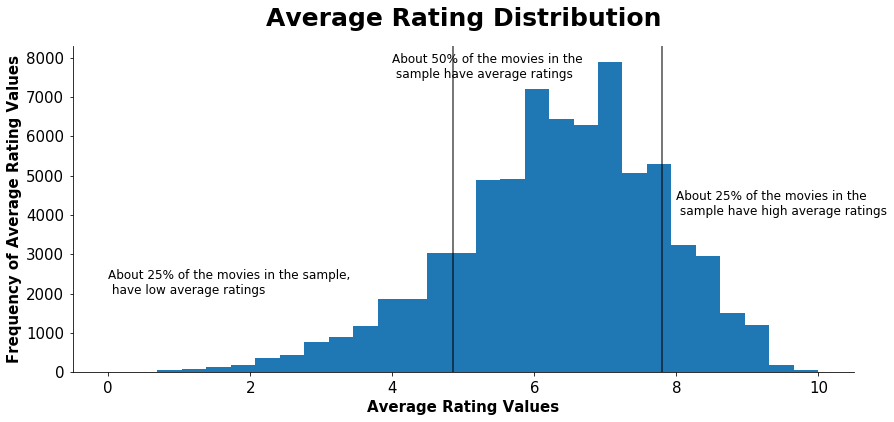

In [32]:
# Generate a figure with a single axis
figure1, ax = plt.subplots(figsize = (14, 6))
#Generate a histogram on the ax
x = movie_ratings_info['average_rating']
ax.hist(x, bins = 29, range = (0, 10))

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Set axes labels
ax.set_xlabel('Average Rating Values', fontsize = 15, weight = 'bold')
ax.set_ylabel('Frequency of Average Rating Values', fontsize = 15, weight = 'bold')
#adjusting tick parameter
ax.tick_params('both', labelsize = 15, pad = 5)
#setting figure title
ax.set_title('Average Rating Distribution', pad = 20, fontsize = 25, weight = 'bold')

# adding vertical lines to create section of data
# 1 std dev on either side of the mean
ax.axvline(4.85, color = 'black', alpha = 0.7)
ax.axvline(7.8, color = 'black', alpha = 0.7)

#Adding text to indicate sample proportions in distribution
ax.text(0,  2000, 'About 25% of the movies in the sample, \n have low average ratings', fontsize = 12)
ax.text(4, 7500, 'About 50% of the movies in the \n sample have average ratings', fontsize = 12)
ax.text(8, 4000, 'About 25% of the movies in the \n sample have high average ratings', fontsize = 12)

figure1.savefig('./images/Average Rating Distribution')
plt.show();

In [33]:
movie_ratings_info.corr()

,vote_average,vote_count,runtime_minutes,averagerating,numvotes,average_rating,number_votes
vote_average,1.000000,0.021686,-0.006521,0.912639,0.030176,0.978814,0.032288
vote_count,0.021686,1.000000,0.008666,0.022458,0.285556,0.022562,0.470698
runtime_minutes,-0.006521,0.008666,1.000000,-0.007132,0.012249,-0.006988,0.013079
averagerating,0.912639,0.022458,-0.007132,1.000000,0.044023,0.976999,0.045196
numvotes,0.030176,0.285556,0.012249,0.044023,1.000000,0.037794,0.979968
average_rating,0.978814,0.022562,-0.006988,0.976999,0.037794,1.000000,0.039482
number_votes,0.032288,0.470698,0.013079,0.045196,0.979968,0.039482,1.000000


Out of 13801 movies, 10081 0r 73% of the sample of movies had average ratings over 5 points whereas only 2627 or 20% of the sample of movies had average ratings over 8

The correlation between the average_rating and number of votes is a very low positive. There is not significant effect on the average rating of a movie as more people voted. The ratings are reflective of how well liked a movie was by the people who watched it.

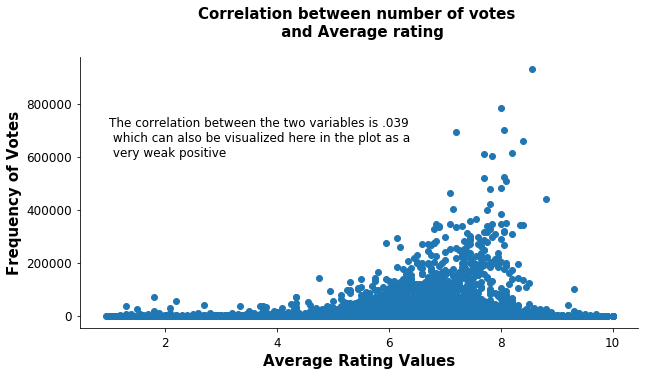

In [34]:
# Generating Figure
figure2, ax = plt.subplots(figsize = (10,5))
# Generating scatter plot to preview variable relationship
x = movie_ratings_info['average_rating']
y = movie_ratings_info['number_votes']
ax.scatter(x,y)

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Set axes labels
ax.set_xlabel('Average Rating Values', fontsize = 15, weight = 'bold')
ax.set_ylabel('Frequency of Votes', fontsize = 15, weight = 'bold')

#adjusting tick parameter
ax.tick_params('both', labelsize = 12, pad = 5)

#setting figure title
ax.set_title('Correlation between number of votes \n and Average rating', pad = 20, fontsize = 15, weight = 'bold')

# adding text to axes explaining correlation
ax.text(1, 600000, 'The correlation between the two variables is .039 \n which can also be visualized here in the plot as a  \n very weak positive', fontsize =12)

# saving figure as .png file
figure2.savefig('./images/Ratings Corr')

plt.show();

In [35]:
genres_list = genre_id_to_string.values()

genre_counter = {}
genre_counter = dict.fromkeys(genres_list)

for genre in genre_counter.keys():
    genre_counter[genre] =  0

In [36]:
# I want to create a genre counter to see how many times a genre appears in the group of movies with ratings higher than 8

for genre_list in movie_ratings_info['genre_ids']:
    for genre in genre_list:
        if genre in genre_counter.keys(): 
            genre_counter[genre] += 1
        
        

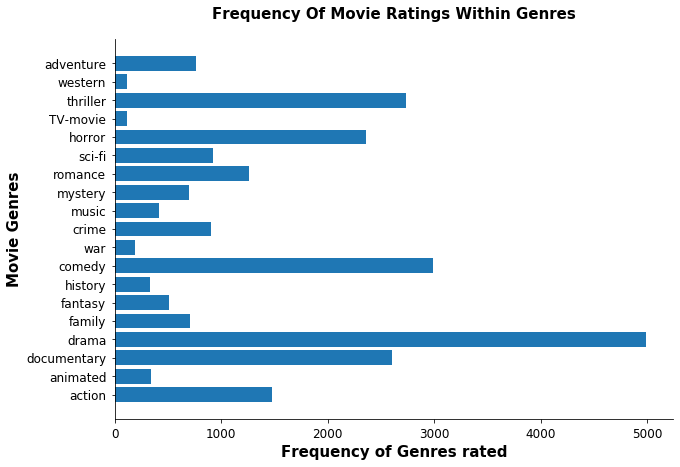

In [37]:
# Generating figure
figure3, ax = plt.subplots(figsize = (10, 7))

# generating a horizontal bar plot on the ax
x = list(genre_counter.values())
y = list(genre_counter.keys())
ax.barh(y, x)

#Setting axes labels
ax.set_xlabel('Frequency of Genres rated', fontsize = 15, weight = 'bold')
ax.set_ylabel('Movie Genres', fontsize = 15, weight = 'bold')

#adjusting tick parameter
ax.tick_params('both', labelsize = 12, pad = 5)

#setting figure title
ax.set_title('Frequency Of Movie Ratings Within Genres', pad = 20, fontsize = 15, weight = 'bold')

#Hiding top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

figure3.savefig('./images/No of ratings within genre')
plt.show;

In [38]:
ratings_more_than_8 = movie_ratings_info[movie_ratings_info['average_rating'] > 8]  

ratings_over_8 = ratings_more_than_8[ratings_more_than_8['number_votes'] > 50]


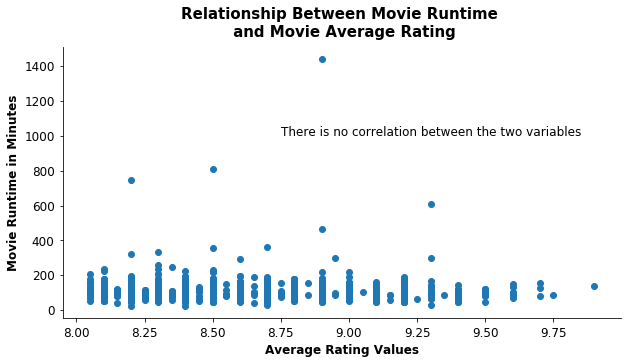

In [40]:
# Generating Figure
figure4, ax = plt.subplots(figsize = (10, 5))
# Generating scatter plot to preview variable relationship
x = ratings_over_8['average_rating']
y = ratings_over_8['runtime_minutes']
ax.scatter(x,y)

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Set axes labels
ax.set_xlabel('Average Rating Values', fontsize = 12, weight = 'bold')
ax.set_ylabel('Movie Runtime in Minutes', fontsize = 12, weight = 'bold')

# #adjusting tick parameter
ax.tick_params('both', labelsize = 12, pad = 5)

#setting figure title
ax.set_title('Relationship Between Movie Runtime \n and Movie Average Rating', pad = 10, fontsize = 15, weight = 'bold')

# # Adding explanatory text
ax.text(8.75, 1000, 'There is no correlation between the two variables', fontsize =12)

figure4.savefig('./images/Movie Runtime and Average Rating Corr')

plt.show();

In [41]:
ratings_over_8['runtime_minutes'].mean()

109.01646706586827

In [42]:
ratings_over_8['runtime_minutes'].std()

59.84808256794522